In [87]:
import json
import matplotlib.pyplot as plt

In [88]:
def importData(file):
        
    #open json file
    with open(file) as f:
        data = json.load(f)

    keys=[i for i in data.keys()]

    d_vectors={}

    for key in keys:
        
        d_vectors[key]={}
        vectors=data[key]['vectors']

        measurement=data[key]['attributes']['measurement']
        repetition=data[key]['attributes']['repetition']

        d_vectors[key]['measurement']=measurement
        d_vectors[key]['repetition']=int(repetition)


        for a in vectors:
            # print(f"{a['module']}, {a['name']}")
            values=a['value']
            mean=sum(values)/len(values)
            # print(mean)

            module=a['module']
            name = a['name']

            if not module in d_vectors[key]:
                d_vectors[key][module]={}
            d_vectors[key][module][name]={}
            d_vectors[key][module][name]['time']=a['time']
            d_vectors[key][module][name]['value']=a['value']
    return d_vectors

d_vectors=importData('../multicore_sched/simulations/test.json')


In [89]:
iterationvars=['numCpus','meanProcessDuration']

In [90]:
measurements=[]
numRepetitions=0

for key in d_vectors:

    measurement=d_vectors[key]['measurement']
    repetition=d_vectors[key]['repetition']

    if not measurement in measurements:
        measurements.append(measurement)
    
    numRepetitions=max(numRepetitions,repetition+1)

In [91]:
import colorsys
def getColors(numColors,numVariations):
    colors=[]
    for i in range(numColors):
        hue = i/numColors
        colors.append([])
        for j in range(numVariations):
            lightness = 0.4 + j / numVariations / 3  # Adjusting to reduce white
            saturation = 0.6 + j / numVariations / 3  # Adjusting to reduce white
            colors[i].append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

numColors = len(measurements)
numVariations = numRepetitions
colors = getColors(numColors, numVariations)

In [92]:
def showColors():
    # Plot colors
    fig, ax = plt.subplots(figsize=(numVariations, numColors))
    for i, row in enumerate(colors):
        for j, color in enumerate(row):
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color))

    ax.set_xlim(0, numVariations)
    ax.set_ylim(0, numColors)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    plt.show()
# showColors()

In [93]:
def measurementLabel(measurement):
    for j, iterationvar in enumerate(iterationvars):
        measurement = measurement.replace(f"${j}", f"{iterationvar}")
    measurement = measurement.replace(', ', '\n')
    return measurement

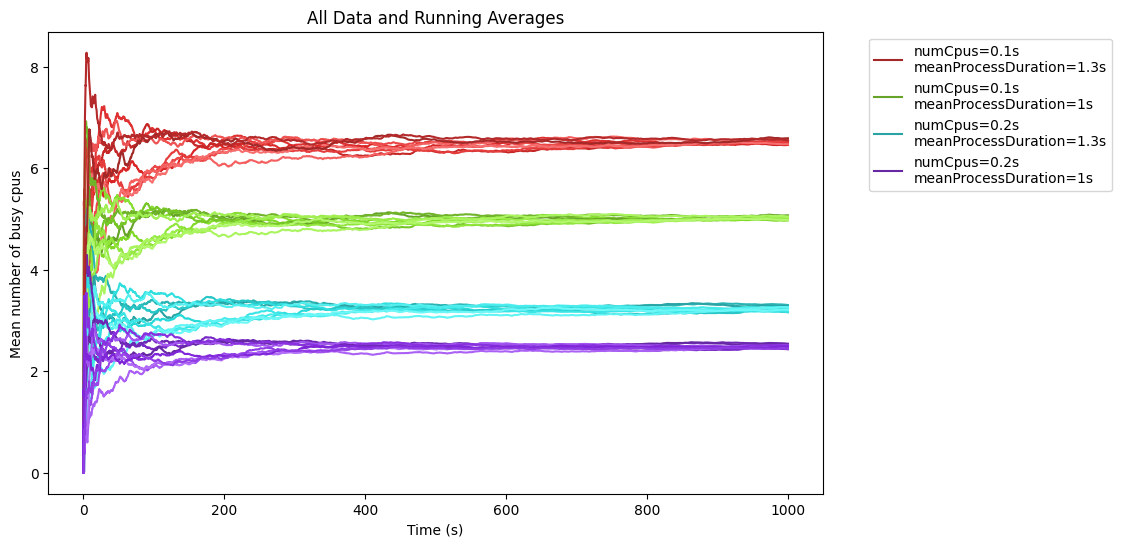

In [98]:
import matplotlib.pyplot as plt

for key in d_vectors:

    measurement=d_vectors[key]['measurement']
    repetition=d_vectors[key]['repetition']

    color=colors[measurements.index(measurement)][repetition]

    time = d_vectors[key]["Computer.scheduler"]["numBusyCpus:vector"]["time"]
    value = d_vectors[key]["Computer.scheduler"]["numBusyCpus:vector"]["value"]

    # Calculate running average
    cumulative_sum = 0
    running_average = []
    time=time+[1000]
    running_average.append(0)
    for i, v in enumerate(value):
        cumulative_sum += v * (time[i+1] - time[i])
        running_average.append(cumulative_sum / time[i+1])

    plt.plot(time, running_average,color=color)

# Plt labels
for i, measurement in enumerate(measurements):
    plt.plot([], [], color=colors[i][0], label=f'{measurementLabel(measurement)}')

plt.xlabel('Time (s)')
plt.ylabel('Mean number of busy cpus')
plt.title('All Data and Running Averages')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gcf().set_size_inches(10, 6)
plt.show()